In [102]:
import tensorflow as tf
import numpy as np
from tensorflow.data.experimental import AUTOTUNE
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras import Model
from keras.applications import ResNet152V2
from keras.optimizers import Adam


In [103]:
IMAGE_SIZE = [224, 224] # at this size, a GPU will run out of memory. Use the TPU
HEIGHT = 224
WIDTH = 224
EPOCHS = 5
BUFFER_SIZE = 60000
# BATCH_SIZE = 16 * strategy.num_replicas_in_sync
BATCH_SIZE = 25

NUM_TRAINING_IMAGES = 12753
NUM_TEST_IMAGES = 7382
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

In [104]:
training_filepath = tf.io.gfile.glob('tfrecords-jpeg-224x224/train/*.tfrec')
validation_filepath = tf.io.gfile.glob('tfrecords-jpeg-224x224/val/*.tfrec')
test_filepath = tf.io.gfile.glob('tfrecords-jpeg-224x224/test/*.tfrec')

In [105]:
raw_training_dataset = tf.data.TFRecordDataset(training_filepath)
raw_validation_dataset = tf.data.TFRecordDataset(validation_filepath)
raw_test_dataset = tf.data.TFRecordDataset(test_filepath)

In [106]:
labeled_feature_description = {
    'class': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string)
}

unlabeled_feature_description = {
    'id': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([], tf.string)
}

In [107]:
CLASSES = [
    'pink primrose',        'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',      'wild geranium',         # 00-04
    'tiger lily',           'moon orchid',               'bird of paradise', 'monkshood',      'globe thistle',         # 05-09
    'snapdragon',           "colt's foot",               'king protea',      'spear thistle',  'yellow iris',           # 10-14
    'globe-flower',         'purple coneflower',         'peruvian lily',    'balloon flower', 'giant white arum lily', # 15-19
    'fire lily',            'pincushion flower',         'fritillary',       'red ginger',     'grape hyacinth',        # 20-24
    'corn poppy',           'prince of wales feathers',  'stemless gentian', 'artichoke',      'sweet william',         # 25-29
    'carnation',            'garden phlox',              'love in the mist', 'cosmos',         'alpine sea holly',      # 30-34
    'ruby-lipped cattleya', 'cape flower',               'great masterwort', 'siam tulip',     'lenten rose',           # 35-39
    'barberton daisy',      'daffodil',                  'sword lily',       'poinsettia',     'bolero deep blue',      # 40-44
    'wallflower',           'marigold',                  'buttercup',        'daisy',          'common dandelion',      # 45-49
    'petunia',              'wild pansy',                'primula',          'sunflower',      'lilac hibiscus',        # 50-54
    'bishop of llandaff',   'gaura',                     'geranium',         'orange dahlia',  'pink-yellow dahlia',    # 55-59
    'cautleya spicata',     'japanese anemone',          'black-eyed susan', 'silverbush',     'californian poppy',     # 60-64
    'osteospermum',         'spring crocus',             'iris',             'windflower',     'tree poppy',            # 65-69
    'gazania',              'azalea',                    'water lily',       'rose',           'thorn apple',           # 70-74
    'morning glory',        'passion flower',            'lotus',            'toad lily',      'anthurium',             # 75-79
    'frangipani',           'clematis',                  'hibiscus',         'columbine',      'desert-rose',           # 80-84
    'tree mallow',          'magnolia',                  'cyclamen ',        'watercress',     'canna lily',            # 85-89
    'hippeastrum ',         'bee balm',                  'pink quill',       'foxglove',       'bougainvillea',         # 90-94
    'camellia',             'mallow',                    'mexican petunia',  'bromelia',       'blanket flower',        # 95-99
    'trumpet creeper',      'blackberry lily',           'common tulip',     'wild rose'                                #100-103
]

In [108]:
def _parse_labeled_image_function(example_proto):
    example = tf.io.parse_single_example(example_proto, labeled_feature_description)
    image = tf.io.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, IMAGE_SIZE)
    label = tf.cast(example['class'], tf.int32)
    return image, label

def _parse_unlabeled_image_function(example_proto):
    example = tf.io.parse_single_example(example_proto, unlabeled_feature_description)
    image = tf.io.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, IMAGE_SIZE)
    idnum = example['id']
    return image, idnum

In [109]:
# Parse labeled images, shuffle and batch
training_dataset = (
    raw_training_dataset
    .map(_parse_labeled_image_function)
    .repeat()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Parse unlabeled images and batch
validation_dataset = (
    raw_validation_dataset
    .map(_parse_labeled_image_function)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Parse unlabeled images and batch
test_dataset = (
    raw_test_dataset
    .map(_parse_unlabeled_image_function)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

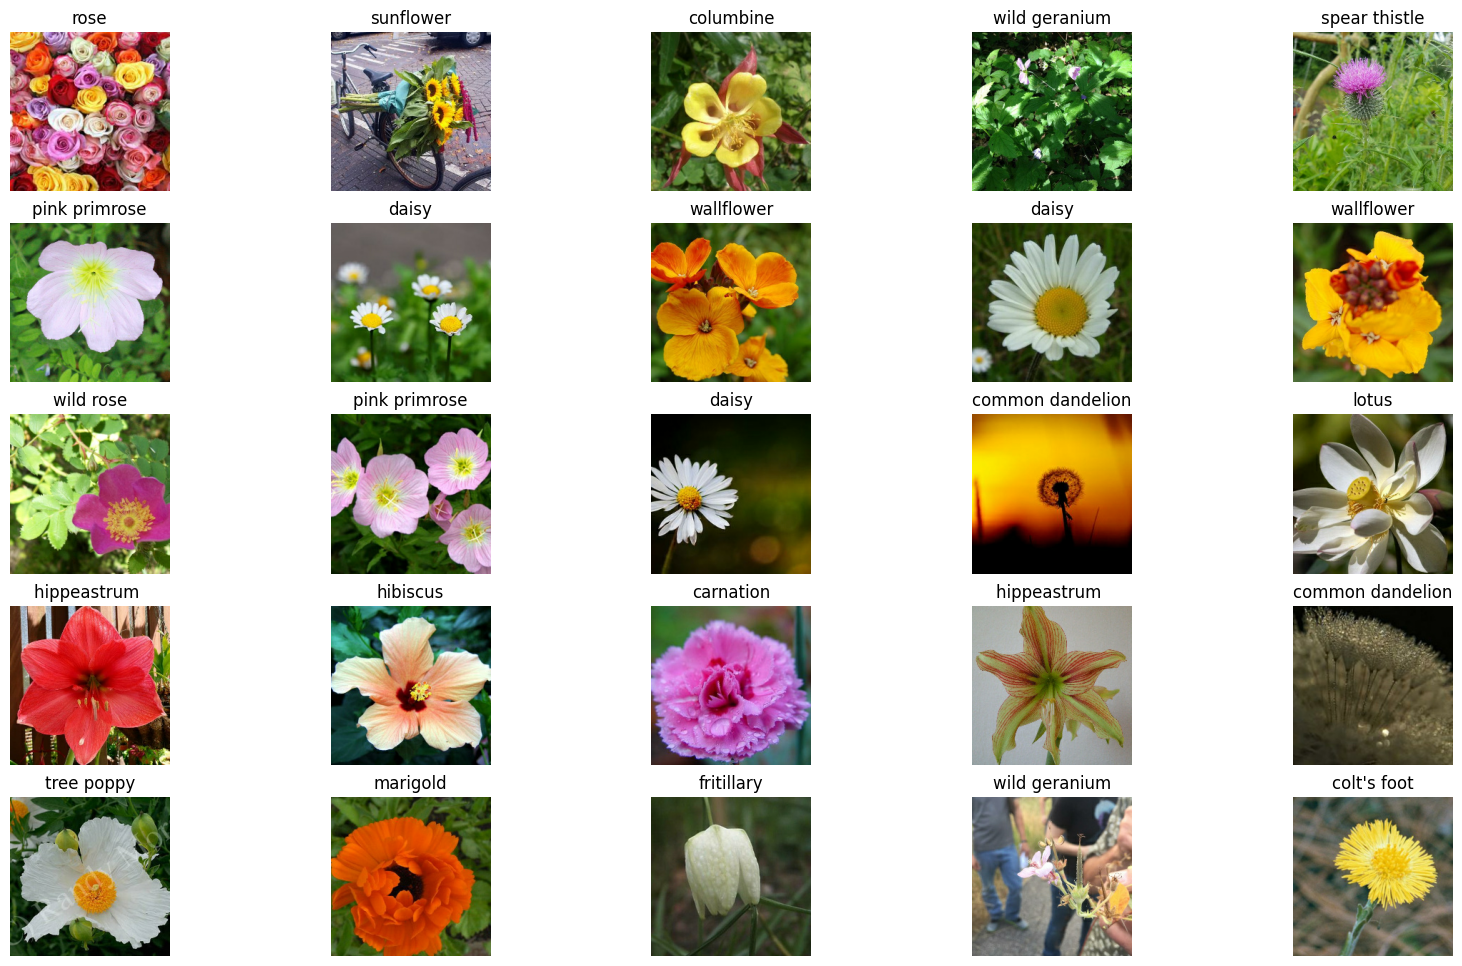

In [110]:
image_batch, label_batch = next(iter(training_dataset))
# print(image_batch, label_batch)
# print(len(image_batch))
# print(len(label_batch))

def display_images(image_batch, label_batch):
    plt.figure(figsize = [20,12])
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(image_batch[i])
        plt.title(CLASSES[label_batch[i].numpy()])
        plt.axis('off')
    plt.show()

display_images(image_batch, label_batch)

In [111]:
def augment_image(image, label):
    # Add 10px padding and random crop
    image = tf.image.resize_with_crop_or_pad(image, HEIGHT+10, WIDTH+10)
    image = tf.image.random_crop(image, size=[*IMAGE_SIZE, 3])

    # Random flip
    image = tf.image.random_flip_left_right(image)

    # Random brightness
    image = tf.image.random_brightness(image, 0.2)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    return image, label

In [112]:
training_dataset_augmented = (
    raw_training_dataset
    .map(_parse_labeled_image_function)
    .map(augment_image)
    .repeat()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [113]:
def build_model():
    inputs = Input(shape=(HEIGHT, WIDTH, 3))
    model = ResNet152V2(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = GlobalAveragePooling2D()(model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(104, activation="softmax")(x)

    # Compile
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-2), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["sparse_categorical_accuracy"])
    
    return model

In [114]:
model = build_model()

hist = model.fit(training_dataset_augmented, 
                 epochs=EPOCHS*2, 
                 validation_data=validation_dataset, 
                 steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1/10
510/510 [==============================] - 319s 529ms/step - loss: 2.9147 - sparse_categorical_accuracy: 0.5767 - val_loss: 1.9339 - val_sparse_categorical_accuracy: 0.6654
Epoch 2/10
510/510 [==============================] - 301s 590ms/step - loss: 1.3826 - sparse_categorical_accuracy: 0.7169 - val_loss: 1.4949 - val_sparse_categorical_accuracy: 0.7023
Epoch 3/10
510/510 [==============================] - 501s 984ms/step - loss: 1.0864 - sparse_categorical_accuracy: 0.7475 - val_loss: 1.3660 - val_sparse_categorical_accuracy: 0.7311
Epoch 4/10
510/510 [==============================] - 308s 605ms/step - loss: 0.9882 - sparse_categorical_accuracy: 0.7641 - val_loss: 1.5778 - val_sparse_categorical_accuracy: 0.7093
Epoch 5/10
510/510 [==============================] - 312s 612ms/step - loss: 1.0418 - sparse_categorical_accuracy: 0.7648 - val_loss: 1.6473 - val_sparse_categorical_accuracy: 0.7236
Epoch 6/10
510/510 [==============================] - 317s 621ms/step - loss: 1.

In [115]:
test_images = test_dataset.map(lambda image, idnum: image)
prob = model.predict(test_images)
pred = np.argmax(prob, axis=-1)
print(pred)

296/296 [==============================] - 122s 405ms/step
[ 9 37  4 ... 10 17 67]


In [116]:
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

np.savetxt(
    'submission.csv',
    np.rec.fromarrays([test_ids, pred]),
    fmt=['%s', '%d'],
    delimiter=',',
    header='id,label',
    comments='',
)